### Training Deep NN
- **The Vanishing/Exploding Gradients Problems** - what activation function adjustement to use, batch normalization etc.
  <br></br>
- **Reusing Pretrained Layers** - use prior models to safe time, or if limited labels data available 
  <br></br>
- **Faster Optimizers**
  <br></br>
- **Avoiding Overfitting Through Regularization**

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Vanishing/Exploding Gradients

- Deep NN suffers from unstable gradients, different layers train at different speeds
    - **Vanishing Gradients** - during back-propagation, gradients often get smaller and smaller in the lower hidden layers, weights change very little from iteration to iteration, solution not optimal
    - **Exploding Gradients** - opposite, weights get incredibly large (especially in RNN)
  <br></br>
- The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks). Looking at the logistic activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

Saving figure sigmoid_saturation_plot


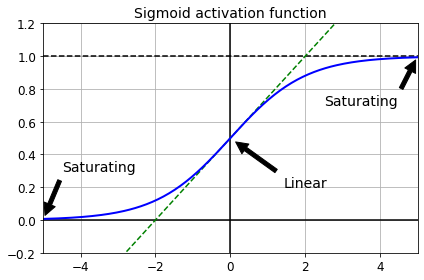

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

#### Xavier and He Initialization

- in order for the signal to slow properly forward (prediction) and back (backpropagation) with no dying or exploding, we need:
    - var(each layer output) = var(each layer input) [forward prediction]
    - var(gradient into a layer) = var(gradient into a layer) [during back-propagation]
- to guarantee it, we wound need same number of inputs (**fan-in**) and neurons (**fan-out**) in each layer…
- … but Glorot and Bengio found a practical compromise →

<img src="screenshots/ch_11/2022-10-11-07-36-26.png" width="600px" img/>

Other initializations:

<img src="screenshots/ch_11/2022-10-11-07-37-12.png" width="600px" img/>

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting kernel_initializer="he_uniform" or kernel_initializer="he_normal" like this:

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on fan-avg rather than fan-in, you can use the VarianceScaling initializer like this:

In [ ]:
init= keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

In [6]:
print([name for name in dir(keras.initializers) if not name.startswith("_")])

['Constant', 'GlorotNormal', 'GlorotUniform', 'HeNormal', 'HeUniform', 'Identity', 'Initializer', 'LecunNormal', 'LecunUniform', 'Ones', 'Orthogonal', 'RandomNormal', 'RandomUniform', 'TruncatedNormal', 'VarianceScaling', 'Zeros', 'constant', 'deserialize', 'get', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform', 'identity', 'lecun_normal', 'lecun_uniform', 'ones', 'orthogonal', 'random_normal', 'random_uniform', 'serialize', 'truncated_normal', 'variance_scaling', 'zeros']


#### Nonsaturating Activation Functions

- in addition to initialization, wrong activation function causes unstable gradients as well e.g. dying **ReLU** may cause some neurons to “die” (weight 0 or negative as ReLU will overwrite it to 0 as it cannot be negative), it happens especially with large learning rate.
- solution could be
    - **“leaky ReLU”**, with **alpa** parm (typically 0.01) to measure slope for z< 0
    - **“randomize leaky RReLU”**, with **alpa** randomized at each iteration
    - **“parametric  PReLU”**, with **alpa** learned during training like any other hypeparameter (great for large image datasets, less so on smaller datasets)

#### "leaky ReLU"

ReLU functions available

 ['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']
Saving figure leaky_relu_plot


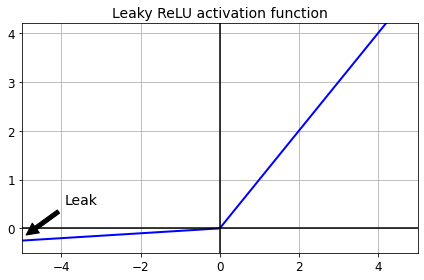

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

print("ReLU functions available\n\n",[m for m in dir(keras.layers) if "relu" in m.lower()])

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Let's train a neural network on Fashion MNIST using the Leaky ReLU:


In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),                               ## add activation function after layer you want to apply it to...
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [12]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6816 - accuracy: 0.7720 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

Now let's try PReLU:

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
            
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7184
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7632
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6564 - val_accuracy: 0.7886
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6331 - accuracy: 0.7910 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8184
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

#### ELU

ELU exponential linear unit-  altenative to ReLU activation func - it takes negative values with z<0 that helps alleviate vanishing gradient problem, it has non-negative gradient at z<0 to avoid dead neutrons. If alpa set to 1 it smooth everywhere, no bumps for gradient descent. But it’s slower than ReLU

<img src="screenshots/ch_11/2022-10-11-07-42-06.png" width="600px" img/>

Saving figure elu_plot


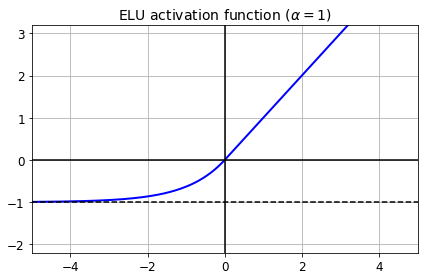

In [14]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

#### SELU
- **SELU - scaled ELU-** alternative to the above. if we scale inputs, this function will “self-normalize” with weights mean=0 and std=1 at each layer, so no vanishing gradient problem.
    - inputs need to standardized with mean=0 and std=1
    - every hidden layer’s weight need to be initialized with LeCun normal initialization, setting **kernel_initializer="lecun_normal"**
    - only sequential API models

This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [15]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [16]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


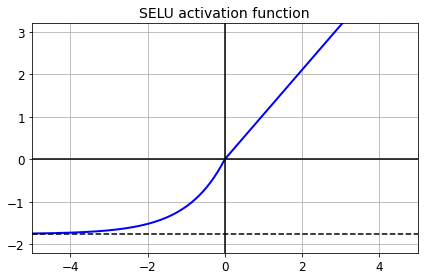

In [17]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [18]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [19]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [21]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [22]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 19s 10ms/step - loss: 1.2544 - accuracy: 0.5151 - val_loss: 0.8895 - val_accuracy: 0.6850
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.9710 - accuracy: 0.6400 - val_loss: 1.0012 - val_accuracy: 0.6448
Epoch 3/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8373 - accuracy: 0.6965 - val_loss: 0.7771 - val_accuracy: 0.7212
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6700 - accuracy: 0.7585 - val_loss: 0.6726 - val_accuracy: 0.7606
Epoch 5/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.5904 - accuracy: 0.7866 - val_loss: 0.5589 - val_accuracy: 0.7996


Now look at what happens if we try to use the ReLU activation function instead:

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 17s 9ms/step - loss: 1.7690 - accuracy: 0.2874 - val_loss: 1.1932 - val_accuracy: 0.5006
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.0852 - accuracy: 0.5472 - val_loss: 1.2314 - val_accuracy: 0.4452
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.0093 - accuracy: 0.5884 - val_loss: 0.8674 - val_accuracy: 0.6310
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8411 - accuracy: 0.6697 - val_loss: 0.7190 - val_accuracy: 0.7250
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8119 - accuracy: 0.6905 - val_loss: 0.7479 - val_accuracy: 0.7080


Not great at all, we suffered from the vanishing/exploding gradients problem.!!!

- **TIP:**
    - in general **SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic**
    - If the network’s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0).
    - If you care a lot about runtime latency, then you may prefer leaky ReLU.
    - If you don’t want to tweak yet another hyperparameter, you may use the default α values used by Keras (e.g., 0.3 for leaky ReLU).
    - If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set.
    - That said, because ReLU is the most used activation function (by far), many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.

#### Batch normalization
- further guardrails to prevent vanishing gradient. each batch is “normalized” i.e. zero-center and normalize each input, then scales and shifts the results with two new parameters that are learned during training
- great for large computer vision predictions
- it takes longer to train, but learns and improves quicker so the oveall “wall time” could be shorther
- if used, no standardized scaling is needed
- add after layers or before, also the the input layer (after flattening)

<img src="screenshots/ch_11/2022-10-11-07-44-34.png" width="600px" img/>
<img src="screenshots/ch_11/2022-10-11-07-45-18.png" width="600px" img/>

For Test  and Predictions we may want to predict only few observations, so mean and std would be unreliable → therefore we Train as above, but also output 4 parameters that we can use in prediction: mean (exp. smoothing moving average thought the whole process), std, and two normalization parms above

In [26]:
# After
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_5 (Batc  (None, 100)             

bn has four parameters: trainable gamma and beta, and non-trainable record keeping ma mean and var

In [27]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))        

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.8491 - accuracy: 0.7130 - val_loss: 0.5607 - val_accuracy: 0.8088
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5753 - accuracy: 0.8007 - val_loss: 0.4785 - val_accuracy: 0.8370
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5181 - accuracy: 0.8196 - val_loss: 0.4433 - val_accuracy: 0.8470
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4799 - accuracy: 0.8333 - val_loss: 0.4210 - val_accuracy: 0.8520
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4547 - accuracy: 0.8406 - val_loss: 0.4058 - val_accuracy: 0.8596
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4393 - accuracy: 0.8461 - val_loss: 0.3945 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4233 - accuracy: 0.8523 - val_loss: 0.3833 - val_accuracy:

Sometimes applying BN BEFORE the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer has some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0640 - accuracy: 0.6715 - val_loss: 0.6875 - val_accuracy: 0.7838
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6903 - accuracy: 0.7786 - val_loss: 0.5609 - val_accuracy: 0.8174
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6036 - accuracy: 0.8013 - val_loss: 0.5030 - val_accuracy: 0.8372
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5514 - accuracy: 0.8165 - val_loss: 0.4674 - val_accuracy: 0.8450
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5163 - accuracy: 0.8260 - val_loss: 0.4431 - val_accuracy: 0.8512
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4949 - accuracy: 0.8307 - val_loss: 0.4254 - val_accuracy: 0.8582
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4762 - accuracy: 0.8365 - val_loss: 0.4115 - val_accuracy:

momentum-used by the BatchNormalization layer when it updates the exponential moving averages; given a new value v (i.e., a new vector of input means or standard deviations computed over the current batch)

<img src="screenshots/ch_11/2022-10-11-07-47-47.png" width="600px" img/>

#### Gadient Clipping
- clip gradient < threshold during backpropagation (often use in RNN as BatchNormalization is not easy to implement)
- All Keras optimizers accept clipnorm or clipvalue arguments:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
# or
optimizer = keras.optimizers.SGD(clipnorm=1.0)

This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0. The threshold is a hyperparameter you can tune. 

### Reusing Pretrained Layers (transfer learning)
- Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.
- transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks.
- it works well on large deep models, especially CNN models where the learning is more general and focuses on general patterns

<img src="screenshots/ch_11/2022-09-14-22-54-02.png" width="600px" img/>

Example:
Let's split the fashion MNIST training set in two:
- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts).
However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [11]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

print(X_train_A.shape,y_train_A.shape, y_train_A[:30])
print(X_train_B.shape,y_train_B.shape, y_train_B[:30])

(43986, 28, 28) (43986,) [4 0 5 7 7 7 4 4 3 4 0 1 6 3 4 3 2 6 5 3 4 5 1 3 4 2 0 6 7 1]
(200, 28, 28) (200,) [1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1.]


In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])


history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3895 - val_accuracy: 0.8665
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3013 - val_accuracy: 0.8991
Epoch 4/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2972 - accuracy: 0.8975 - val_loss: 0.2893 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2834 - accuracy: 0.9021 - val_loss: 0.2775 - val_accuracy: 0.9071
Epoch 6/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2729 - accuracy: 0.9062 - val_loss: 0.2730 - val_accuracy: 0.9073
Epoch 7/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2719 - val_accuracy:

In [14]:
model_A.save("my_model_A.h5")

In [17]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

model_B.summary()

Epoch 1/20
7/7 [==============================] - 1s 33ms/step - loss: 0.8302 - accuracy: 0.5650 - val_loss: 0.5225 - val_accuracy: 0.7515
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4457 - accuracy: 0.8050 - val_loss: 0.4004 - val_accuracy: 0.8408
Epoch 3/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3428 - accuracy: 0.8850 - val_loss: 0.3317 - val_accuracy: 0.8763
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.2801 - accuracy: 0.9200 - val_loss: 0.2840 - val_accuracy: 0.9047
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.2373 - accuracy: 0.9300 - val_loss: 0.2522 - val_accuracy: 0.9239
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.2068 - accuracy: 0.9450 - val_loss: 0.2289 - val_accuracy: 0.9351
Epoch 7/20
7/7 [==============================] - 0s 12ms/step - loss: 0.1854 - accuracy: 0.9600 - val_loss: 0.2121 - val_accuracy: 0.9351
Epoch 8/20
7/7 [===========

Now let's use Model A to transfer some knowledge and compare the results.

Note that model_B_on_A and model_A actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build model_B_on_A on top of a clone of model_A:

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [19]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))


# compare
print(model_B.evaluate(X_test_B, y_test_B))
print(model_B_on_A.evaluate(X_test_B, y_test_B))

Epoch 1/4
7/7 [==============================] - 1s 35ms/step - loss: 0.8756 - accuracy: 0.4350 - val_loss: 0.8349 - val_accuracy: 0.4868
Epoch 2/4
7/7 [==============================] - 0s 13ms/step - loss: 0.7945 - accuracy: 0.5300 - val_loss: 0.7620 - val_accuracy: 0.5517
Epoch 3/4
7/7 [==============================] - 0s 14ms/step - loss: 0.7224 - accuracy: 0.6200 - val_loss: 0.6998 - val_accuracy: 0.6014
Epoch 4/4
7/7 [==============================] - 0s 13ms/step - loss: 0.6611 - accuracy: 0.6700 - val_loss: 0.6454 - val_accuracy: 0.6501
Epoch 1/16
7/7 [==============================] - 1s 38ms/step - loss: 0.5146 - accuracy: 0.7600 - val_loss: 0.4063 - val_accuracy: 0.8540
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.3397 - accuracy: 0.9000 - val_loss: 0.3007 - val_accuracy: 0.9300
Epoch 3/16
7/7 [==============================] - 0s 13ms/step - loss: 0.2521 - accuracy: 0.9600 - val_loss: 0.2420 - val_accuracy: 0.9635
Epoch 4/16
7/7 [===============

#### Unsupervised Pre-training

<img src="screenshots/ch_11/2022-10-11-07-27-58.png" width="600px" img/>

#### Pretraining on an Auxiliary Task

if you want to build a system to recognize faces, you may only have a few pictures of each individual — clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. You could, however, gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person. Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data.

For natural language processing (NLP) applications, you can download a corpus of millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are (e.g., it should predict that the missing word in the sentence “What ___ you saying?” is probably “are” or “were”). If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data

### Faster Optimizers

##### Momentum Optimizer - each gradient is further multiply by a momentum vector "m"
- prior gradient matters - at each iteration it subtract the local gradient from "m", and it updates the weights by adding his momentum vector
- To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.
- it can help passing the local optima

<img src="screenshots/ch_11/2022-10-12-08-25-26.png" width="600px" img/>

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

##### Nesterov Accelerated Gradient
One small variant to momentum optimization, The Nesterov Accelerated Gradient (NAG) method, also known as Nesterov momentum optimization, measures the gradient of the cost function not at the local position θ but slightly ahead in the direction of the momentum, at θ + βm

- This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position,

- the Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, ∇1 continues to push farther across the valley, while ∇2 pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

<img src="screenshots/ch_11/2022-10-12-08-28-13.png" width="600px" img/>

<img src="screenshots/ch_11/2022-10-12-08-31-53.png" width="600px" img/>

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

##### AdaGrad - scaling down the gradient vector along the steepest dimensions

- efficient for simpler tasks such as Linear Regression,
- but it often stops too early when training neural networks. should not be used for deep networks

<img src="2022-10-12-08-38-00.png" width="600px" img/>

- The first step accumulates the square of the gradients into the vector s (recall that the ⊗ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing si ← si + (∂ J(θ) / ∂ θi)2 for each element si of the vector s; in other words, each si accumulates the squares of the partial derivative of the cost function with regard to parameter θi. If the cost function is steep along the ith dimension, then si will get larger and larger at each iteration.
- The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector is scaled down by a factor of  (the ⊘ symbol represents the element-wise division, and ε is a smoothing term to avoid division by zero, typically set to 10–10). This vectorized form is equivalent to simultaneously computing  for all parameters θi. 
- In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum (see Figure 11-7). One additional benefit is that it requires much less tuning of the learning rate hyperparameter η.

<img src="screenshots/ch_11/2022-10-12-08-40-35.png" width="600px" img/>

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

##### RMSProp
- AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The RMSProp algorithm16 fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step (see Equation 11-7).

<img src="screenshots/ch_11/2022-10-12-08-46-14.png" width="600px" img/>

- The decay rate β is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.
-  Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

##### Adam Optimization - adaptive moment estimation (combines momentum opt + RMSprop)

- just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients

<img src="screenshots/ch_11/2022-10-12-08-50-12.png" width="600px" img/>

The momentum decay hyperparameter β1 is typically initialized to 0.9, while the scaling decay hyperparameter β2 is often initialized to 0.999. As earlier, the smoothing term ε is usually initialized to a tiny number such as 10–7. These are the default values for the Adam class (to be precise, epsilon defaults to None, which tells Keras to use keras.backend.epsilon(), which defaults to 10–7; you can change it using keras.backend.set_epsilon()).
Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter η. You can often use the default value η = 0.001, making Adam even easier to use than Gradient Descent.

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

##### AdaMax - vaiant of Adam, more stable than Adam, but it really depends on the dataset, and in general Adam performs better.

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

##### NADAM - Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

All the optimization techniques discussed so far only rely on the first-order partial derivatives (Jacobians). The optimization literature also contains amazing algorithms based on the second-order partial derivatives (the Hessians, which are the partial derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are n2 Hessians per output (where n is the number of parameters), as opposed to just n Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

##### Optimization comparrison
- *bad, ** aveage, *** good

<img src="screenshots/ch_11/2022-10-12-09-01-21.png" width="600px" img/>

#### Learning Rate scheduling

If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down.

<img src="screenshots/ch_11/2022-10-14-07-29-47.png" width="600px" img/>


When you save a model, the optimizer and its learning rate get saved along with it. This means that with this new schedule function, you could just load a trained model and continue training where it left off, no problem. Things are not so simple if your schedule function uses the epoch argument, however: the epoch does not get saved, and it gets reset to 0 every time you call the fit() method. If you were to continue training a model where it left off, this could lead to a very large learning rate, which would likely damage your model’s weights. One solution is to manually set the fit() method’s initial_epoch argument so the epoch starts at the right value.

##### Power scheduling
Set the learning rate to a function of the iteration number t: η(t) = η0 / (1 + t/s)c. The initial learning rate η0, the power c (typically set to 1), and the steps s are hyperparameters. The learning rate drops at each step. After s steps, it is down to η0 / 2. After s more steps, it is down to η0 / 3, then it goes down to η0 / 4, then η0 / 5, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning η0 and s (and possibly c). 

lr = lr0 / (1 + steps / s)**c
- Keras uses c=1 and s = 1 / decay



Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4881 - accuracy: 0.8289 - val_loss: 0.4026 - val_accuracy: 0.8602
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3803 - accuracy: 0.8660 - val_loss: 0.3707 - val_accuracy: 0.8682
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3471 - accuracy: 0.8766 - val_loss: 0.3692 - val_accuracy: 0.8670
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3258 - accuracy: 0.8840 - val_loss: 0.3475 - val_accuracy: 0.8750
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3104 - accuracy: 0.8898 - val_loss: 0.3425 - val_accuracy: 0.8750
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2967 - accuracy: 0.8941 - val_loss: 0.3406 - val_accuracy: 0.8778
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2865 - accuracy: 0.8983 - val_loss: 0.3351 - val_accuracy:

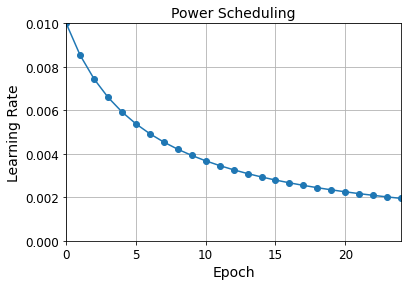

In [22]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

## plot it
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

##### Exponential scheduling
 Set the learning rate to η(t) = η0 0.1t/s. The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps. 

In [24]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8283 - accuracy: 0.7598 - val_loss: 0.9852 - val_accuracy: 0.7480 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6762 - accuracy: 0.7992 - val_loss: 0.6130 - val_accuracy: 0.8156 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5832 - accuracy: 0.8197 - val_loss: 0.7417 - val_accuracy: 0.7792 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5508 - accuracy: 0.8322 - val_loss: 0.5101 - val_accuracy: 0.8546 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4917 - accuracy: 0.8479 - val_loss: 0.5144 - val_accuracy: 0.8568 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4463 - accuracy: 0.8605 - val_loss: 0.5516 - val_accuracy: 0.8616 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 7s

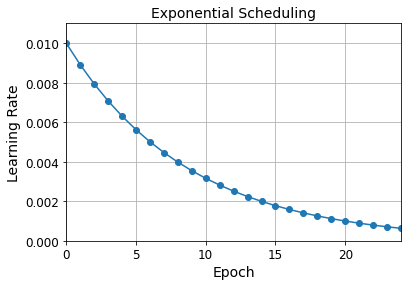

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [26]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [27]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7961 - accuracy: 0.7675 - val_loss: 0.7148 - val_accuracy: 0.7782 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6654 - accuracy: 0.7961 - val_loss: 0.6270 - val_accuracy: 0.8294 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5658 - accuracy: 0.8234 - val_loss: 0.7538 - val_accuracy: 0.7836 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5398 - accuracy: 0.8341 - val_loss: 0.5684 - val_accuracy: 0.8444 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4795 - accuracy: 0.8491 - val_loss: 0.5389 - val_accuracy: 0.8416 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4225 - accuracy: 0.8631 - val_loss: 0.4878 - val_accuracy: 0.8580 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 8s

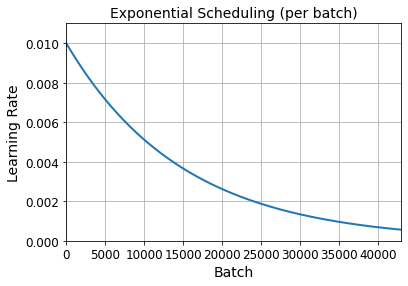

In [28]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

##### Piecewise constant scheduling 
Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them. 

In [29]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8829 - accuracy: 0.7490 - val_loss: 1.2565 - val_accuracy: 0.5710 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 4ms/step - loss: 1.0385 - accuracy: 0.6717 - val_loss: 0.9727 - val_accuracy: 0.6418 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 1.0056 - accuracy: 0.6535 - val_loss: 1.5224 - val_accuracy: 0.5610 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 1.1038 - accuracy: 0.6191 - val_loss: 1.0178 - val_accuracy: 0.6368 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 1.1204 - accuracy: 0.6112 - val_loss: 1.0339 - val_accuracy: 0.6078 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8078 - accuracy: 0.6621 - val_loss: 0.8006 - val_accuracy: 0.6702 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 8s

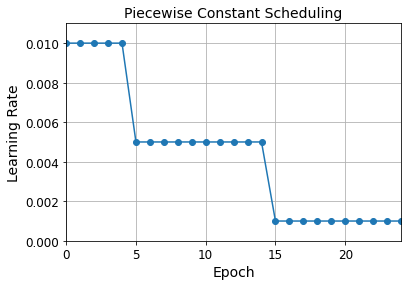

In [30]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

##### Performance scheduling
Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.

lr = lr0 * 0.1**(epoch / s)

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4795 - accuracy: 0.8312 - val_loss: 0.3718 - val_accuracy: 0.8624 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3668 - accuracy: 0.8665 - val_loss: 0.3775 - val_accuracy: 0.8644 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3288 - accuracy: 0.8789 - val_loss: 0.3463 - val_accuracy: 0.8732 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3055 - accuracy: 0.8880 - val_loss: 0.3539 - val_accuracy: 0.8830 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2833 - accuracy: 0.8946 - val_loss: 0.3321 - val_accuracy: 0.8842 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2118 - accuracy: 0.9206 - val_loss: 0.3187 - val_accuracy: 0.8932 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 3s

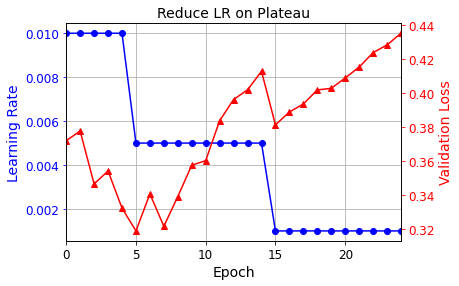

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])
                
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

Lastly, tf.keras offers an alternative way to implement learning rate scheduling: define the learning rate using one of the schedules available in keras.optimizers.schedules, then pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example, here is how to implement the same exponential schedule as the exponential_decay_fn() function we defined earlier:

This is nice and simple, plus when you save the model, the learning rate and its schedule (including its state) get saved as well. This approach, however, is not part of the Keras API; it is specific to tf.keras.

In [32]:
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

##### 1 Cycle scheduling
Contrary to the other approaches, 1cycle (introduced in a 2018 paper21 by Leslie Smith) starts by increasing the initial learning rate η0, growing linearly up to η1 halfway through training. Then it decreases the learning rate linearly down to η0 again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate η1 is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate η0 is chosen to be roughly 10 times lower. When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture).

### Avoiding overfitting through Regularization

<img src="screenshots/ch_11/2023-01-24-18-28-38.png" width="600px" img/>
<img src="screenshots/ch_11/2023-01-24-18-29-29.png" width="600px" img/>